## Fast.ai Deep Learning 1 Practice - Collaborative Filtering

This notebook is practice for Lesson 4 of the [Fast.ai](https://www.fast.ai) course.

In [1]:
from fastai.collab import *
from fastai.tabular import *

In [2]:
user, item, title = 'userId', 'movieId', 'title' 

In [3]:
path = Path('/media/veracrypt3/Cloud/Datasets/ml-100k/')

In [4]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                     names=[user, item, 'rating', 'timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [8]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [9]:
data.show_batch()

userId,title,target
406,Jaws 2 (1978),2.0
655,Up Close and Personal (1996),2.0
60,Manhattan (1979),4.0
653,Die Hard (1988),3.0
655,Groundhog Day (1993),2.0


In [10]:
y_range = [0, 5.5]

In [11]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


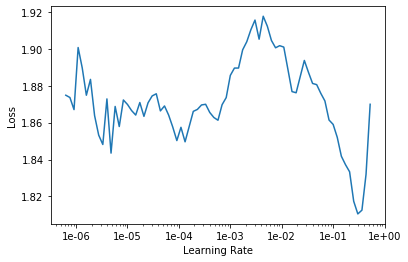

In [12]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [13]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.932178,0.948476,00:04
1,0.848016,0.880998,00:04
2,0.767080,0.834484,00:04
3,0.648855,0.813022,00:04
4,0.558552,0.813720,00:05


In [14]:
learn.save('dotprod')

# Interpretation

In [15]:
learn.load('dotprod');

In [16]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [17]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

In [18]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [19]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i, b in zip(top_movies, movie_bias)]

In [20]:
item0 = lambda o: o[0]

In [22]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3883),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2912), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2685),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2672), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2609), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2477), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2473), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2386), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2327), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2276), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2260), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2231), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2229), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2176), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (t

In [23]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6350), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5956), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5818), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5594), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5468), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5259), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5234), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5132), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4920), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4803), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4785), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4760), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4754), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4594), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4589), 'Vertigo (1958)', 4.251396648044692)]

### Movie weights

In [25]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [26]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [27]:
fac0, fac1, fac2 = movie_pca.t()
movie_comp = [(f, i) for f, i in zip(fac0, top_movies)]

In [28]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2484), 'Home Alone 3 (1997)'),
 (tensor(1.2436), "McHale's Navy (1997)"),
 (tensor(1.1942), 'Jungle2Jungle (1997)'),
 (tensor(1.1721), 'Leave It to Beaver (1997)'),
 (tensor(1.1651), 'Children of the Corn: The Gathering (1996)'),
 (tensor(1.0883), 'Batman & Robin (1997)'),
 (tensor(1.0815), 'Congo (1995)'),
 (tensor(1.0802), 'D3: The Mighty Ducks (1996)'),
 (tensor(1.0558), 'Bio-Dome (1996)'),
 (tensor(1.0492), 'Grease 2 (1982)')]

In [29]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1049), 'Chinatown (1974)'),
 (tensor(-1.0997), 'Casablanca (1942)'),
 (tensor(-1.0191), 'Wrong Trousers, The (1993)'),
 (tensor(-0.9853), 'Lawrence of Arabia (1962)'),
 (tensor(-0.9802), 'Close Shave, A (1995)'),
 (tensor(-0.9701), 'Third Man, The (1949)'),
 (tensor(-0.9631), 'Ran (1985)'),
 (tensor(-0.9586), 'Godfather, The (1972)'),
 (tensor(-0.9537), 'When We Were Kings (1996)'),
 (tensor(-0.9492), 'Some Folks Call It a Sling Blade (1993)')]

In [30]:
movie_comp = [(f, i) for f, i in zip(fac1, top_movies)]

In [31]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8661), 'Keys to Tulsa (1997)'),
 (tensor(0.8632), 'Brazil (1985)'),
 (tensor(0.7951), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.7930), 'Trainspotting (1996)'),
 (tensor(0.7775), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.7743), 'Clockwork Orange, A (1971)'),
 (tensor(0.7622), 'Cable Guy, The (1996)'),
 (tensor(0.7619), 'Dead Man (1995)'),
 (tensor(0.7587), 'Road to Wellville, The (1994)'),
 (tensor(0.7510), 'Stupids, The (1996)')]

In [32]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1095), 'Raiders of the Lost Ark (1981)'),
 (tensor(-1.1010), 'Braveheart (1995)'),
 (tensor(-1.0534), 'Titanic (1997)'),
 (tensor(-0.9020), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8588), 'Forrest Gump (1994)'),
 (tensor(-0.8302), "It's a Wonderful Life (1946)"),
 (tensor(-0.8300), 'Star Wars (1977)'),
 (tensor(-0.8273), 'Pretty Woman (1990)'),
 (tensor(-0.8227), 'Hunt for Red October, The (1990)'),
 (tensor(-0.8195), 'American President, The (1995)')]

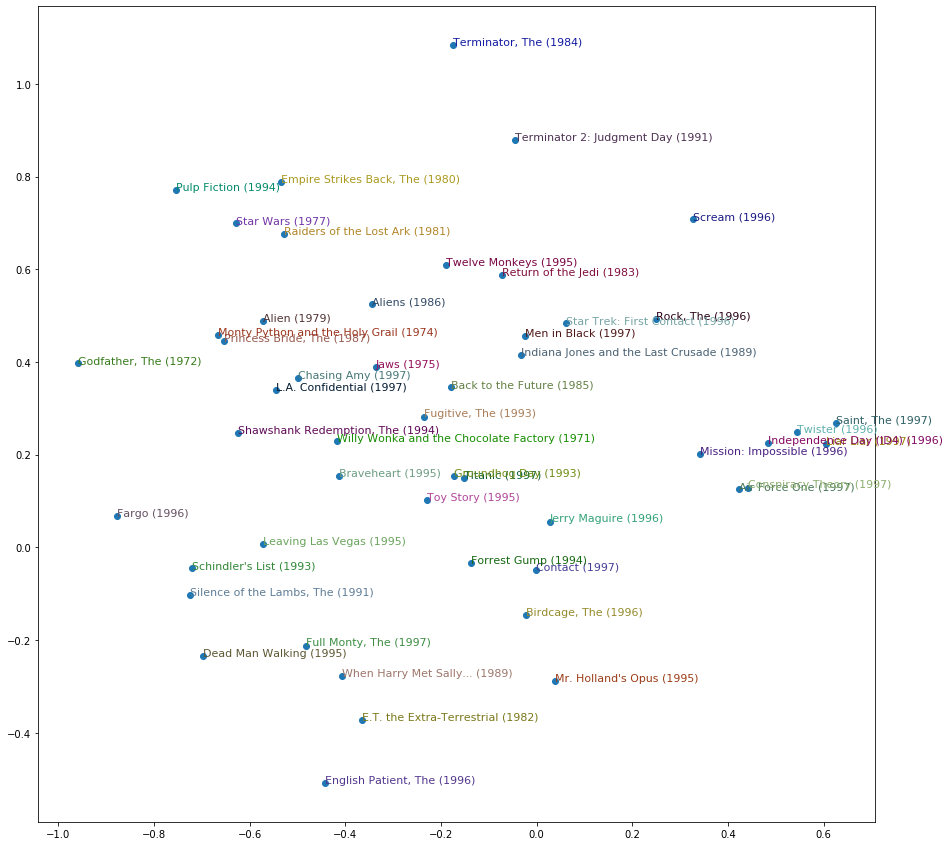

In [34]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15, 15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x, y, i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()